# Lab 3 - GANy
Błażej Nowicki

In [3]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import os

torch.manual_seed(111)

assert torch.cuda.is_available(), "Ten mały manewr kosztował by nas 10 lat"
device = "cuda"

checkpoint_dir = "checkpoints/"


### Rozgrzewka

In [116]:
class MiniModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 10),
            nn.Linear(10, 1),
        )

    def forward(self, x):
        return self.model(x)



batch = 3
model = MiniModel()
loss_function = lambda x: torch.abs(torch.tensor(42.0) - x).mean()
optimizer = torch.optim.Adam(list(model.parameters())[:2], lr=0.1) # 2 bo wagi + bias
epochs = 1000

x = torch.randn((batch, 2))

for e in range(epochs):
    model.zero_grad()
    y = model(x)
    loss = loss_function(y)
    loss.backward()
    optimizer.step()

    if (e + 1) % 100 == 0:
        print(loss)

model.eval()
model(x)



tensor(15.6990, grad_fn=<MeanBackward0>)
tensor(6.1553, grad_fn=<MeanBackward0>)
tensor(4.9915, grad_fn=<MeanBackward0>)
tensor(3.7765, grad_fn=<MeanBackward0>)
tensor(2.5117, grad_fn=<MeanBackward0>)
tensor(1.2427, grad_fn=<MeanBackward0>)
tensor(0.0512, grad_fn=<MeanBackward0>)
tensor(0.0449, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0462, grad_fn=<MeanBackward0>)


tensor([[42.0558],
        [41.9856],
        [42.0294]], grad_fn=<AddmmBackward0>)

Model zbiega do oczekiwanej wartości >42<

In [113]:
model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[ -2.1645, -14.9439],
                      [ -2.4499, -16.0248],
                      [ -3.1218, -15.0403],
                      [  1.8771,  15.7340],
                      [  2.6101,  15.5759],
                      [  2.7396,  14.9644],
                      [ -2.1010, -14.7368],
                      [ -1.8904, -15.8519],
                      [  2.0407,  15.9046],
                      [ -3.1293, -15.9088]])),
             ('model.0.bias',
              tensor([ 25.5340,  24.4872,  25.6582, -24.8000, -25.2096, -24.5091,  24.5038,
                       25.7281, -24.6011,  25.1103])),
             ('model.1.weight',
              tensor([[ 0.0988,  0.0381,  0.0973, -0.1788, -0.0612, -0.2741,  0.1142,  0.0515,
                       -0.0069,  0.2939]])),
             ('model.1.bias', tensor([0.2898]))])

Zmieniły się tylko wagi i bias w pierwszej warstwie. W drugiej zostaly watrości z inicjalizacji.

### Modele

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1),
        )


    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 1024),
            nn.Unflatten(-1, (64, 4, 4)),
            # ----
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # ---
            # nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),
            # nn.LeakyReLU(0.2),
            # nn.BatchNorm2d(64),
            # nn.ConvTranspose2d(64, 128, 4, stride=2, padding=1),
            # nn.LeakyReLU(0.2),
            # nn.BatchNorm2d(128),
            # nn.ConvTranspose2d(128, 256, 4, stride=2, padding=1),
            # nn.LeakyReLU(0.2),
            # nn.BatchNorm2d(256),
            # ---
            nn.Conv2d(256, 3, 5, stride=1, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [4]:
def show(x):
    x = (x + 1) / 2
    plt.imshow(x.permute(1, 2, 0).cpu().detach().numpy())

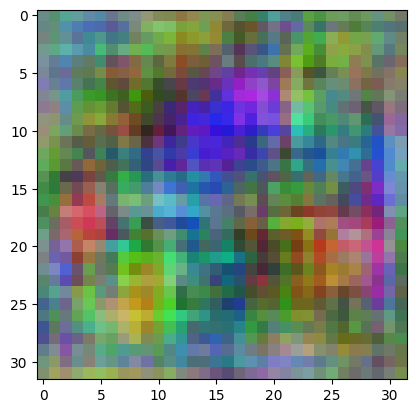

In [6]:
model = Generator()
x = torch.randn(2, 64)
x = model(x)
show(x[0])

Bez zaskoczeń kolorowe plamy. 
Z convTransposed2d nie było płynnych przejść pomiędzy sąsiednimi pikselami.

In [7]:

class CakeDataset(Dataset):
    def __init__(self, data_dir: str):
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.images = []

        for file in os.listdir(data_dir):
            img = Image.open(data_dir + file)
            img = img.resize((32, 32))
            img = transform(img) # [0, 1]
            img = 2 * img - 1 # [-1, 1]
            self.images.append(img)

    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index) -> Image:
        return self.images[index]

In [36]:
dataset = CakeDataset('crawled_cakes/')

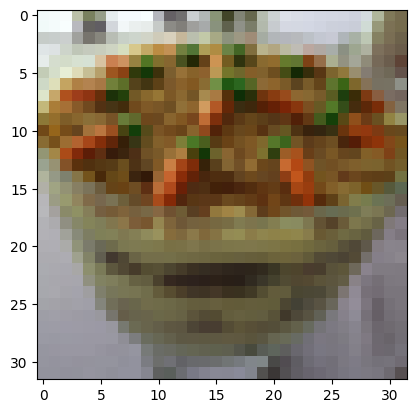

In [42]:
show(dataset[1])

In [ ]:

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

start_epoch = 0
end_epoch = 3000

loss_function = nn.MSELoss().to(device)
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

lr = 0.0001
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

if start_epoch > 0:
    checkpoint = torch.load(checkpoint_dir + f"model_{start_epoch-1}.pt")

    discriminator.load_state_dict(checkpoint['discriminator_weights'])
    generator.load_state_dict(checkpoint["generator_weights"])
    optimizer_discriminator.load_state_dict(checkpoint['discriminator_oprimizer'])
    optimizer_generator.load_state_dict(checkpoint['generator_optimizer'])

for epoch in range(start_epoch, end_epoch):
    for n, real_samples in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )

        input_noise = torch.randn((batch_size, 64)).to(
            device=device
        )
        generated_samples = generator(input_noise)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)

        generator.zero_grad()
        output_discriminator_generated = discriminator(generated_samples)

        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        discriminator.zero_grad()
        output_discriminator_real = discriminator(real_samples)
        output_discriminator_generated = discriminator(generated_samples.detach())

        loss_discriminator = loss_function(
            torch.cat([output_discriminator_real, output_discriminator_generated]),
            torch.cat([real_samples_labels, generated_samples_labels])
        )

        if loss_discriminator > 0.2:
            loss_discriminator.backward()
            optimizer_discriminator.step()

        # Show loss
        if n == len(train_loader) - 1 :

            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
        
        if (epoch+1) % 100 == 0:
            path = checkpoint_dir + f"model_{epoch}.pt"
            torch.save({
                "generator_weights": generator.state_dict(),
                "generator_optimizer": optimizer_generator.state_dict(),
                "discriminator_weights": discriminator.state_dict(),
                "discriminator_oprimizer": optimizer_discriminator.state_dict(),
                "epoch": epoch
            }, path)


In [25]:
def show_epoch(x, epoch):
    checkpoint = torch.load(checkpoint_dir + f"model_{epoch-1}.pt")
    generator = Generator()
    generator.load_state_dict(checkpoint["generator_weights"])
    y = generator(x)
    
    y = (y + 1) / 2
    fig = plt.figure(figsize=(40, 20))
    columns = y.shape[0]
    for i in range(1, columns +1):
        fig.add_subplot(1, columns, i)
        plt.imshow(y[i-1].permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

In [26]:
x = torch.randn((10, 64))

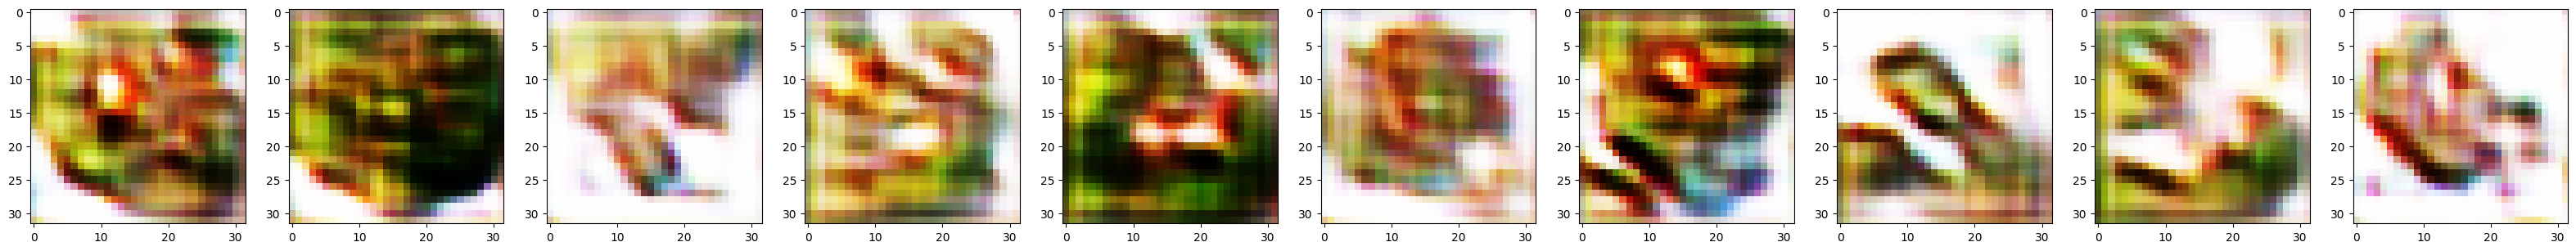

In [27]:
show_epoch(x, 100)

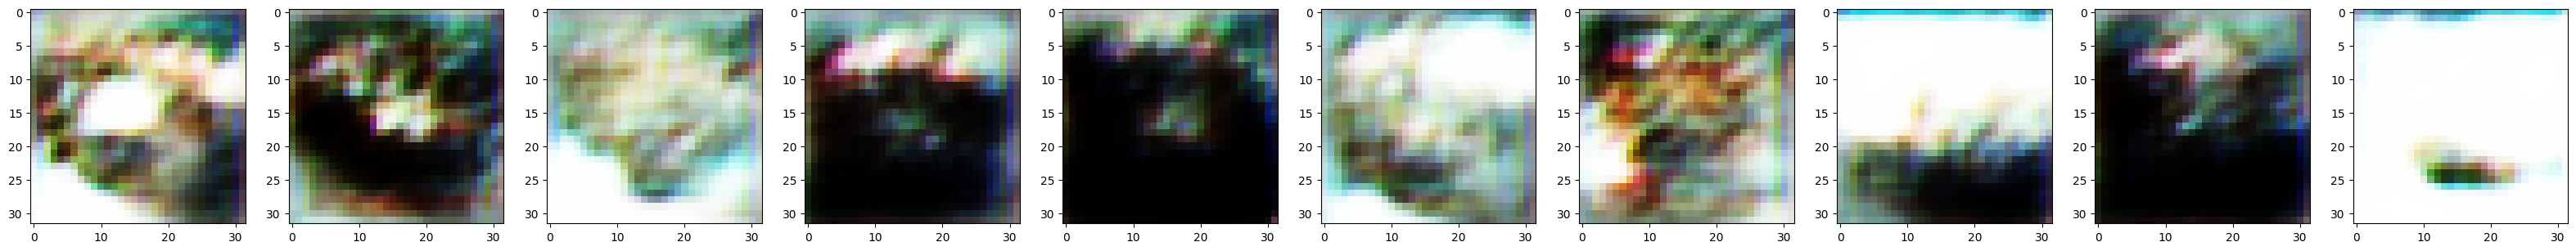

In [28]:
show_epoch(x, 200)

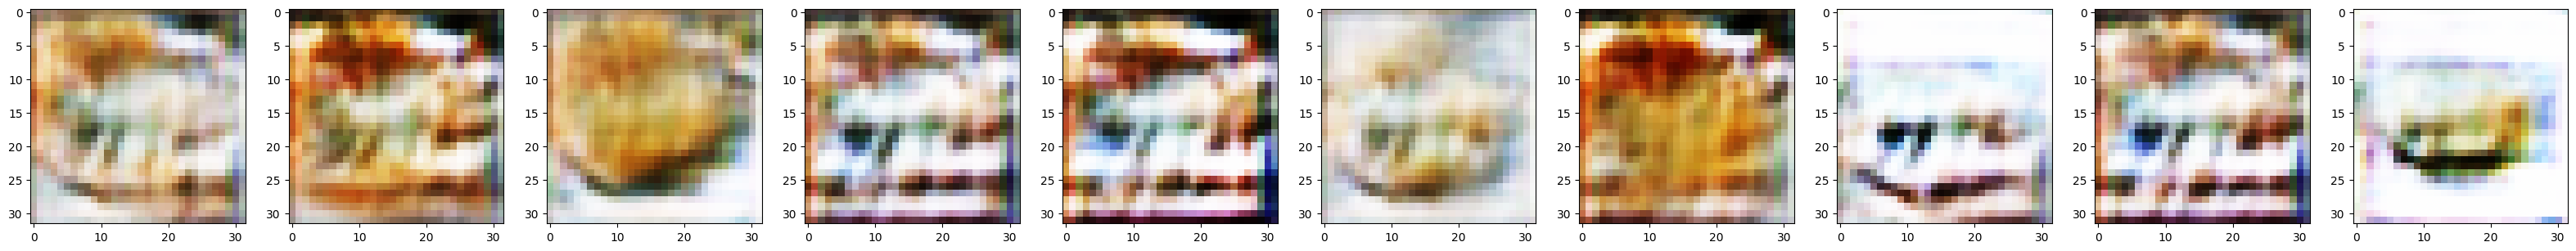

In [29]:
show_epoch(x, 500)

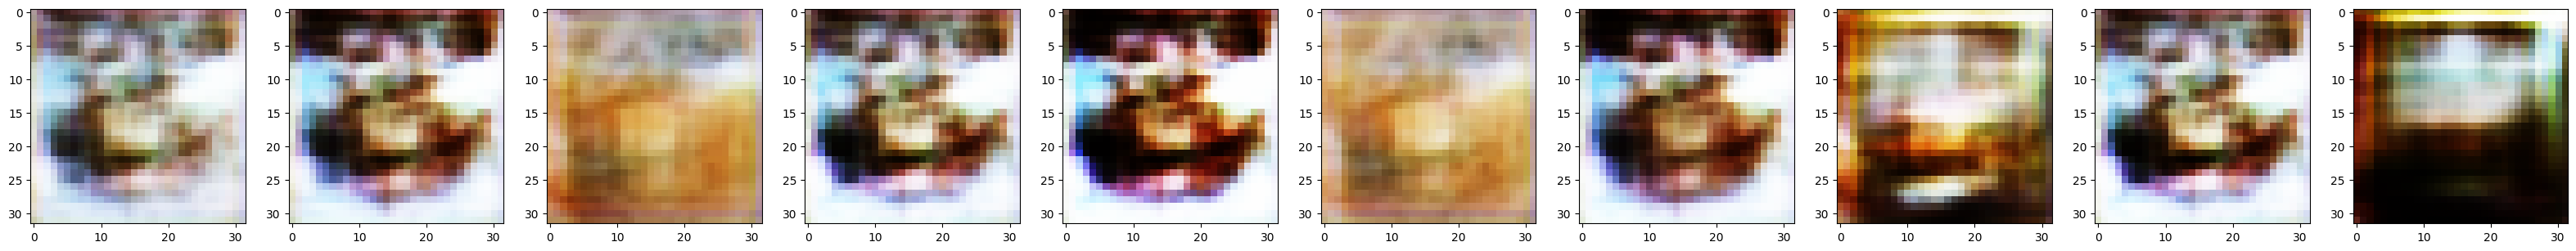

In [30]:
show_epoch(x, 1000)

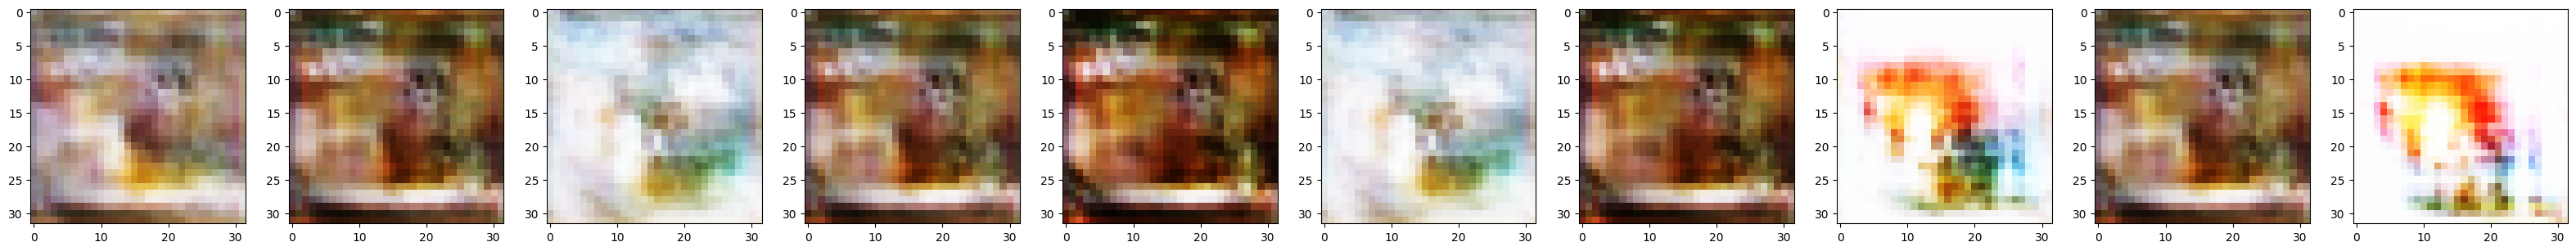

In [31]:
show_epoch(x, 1500)

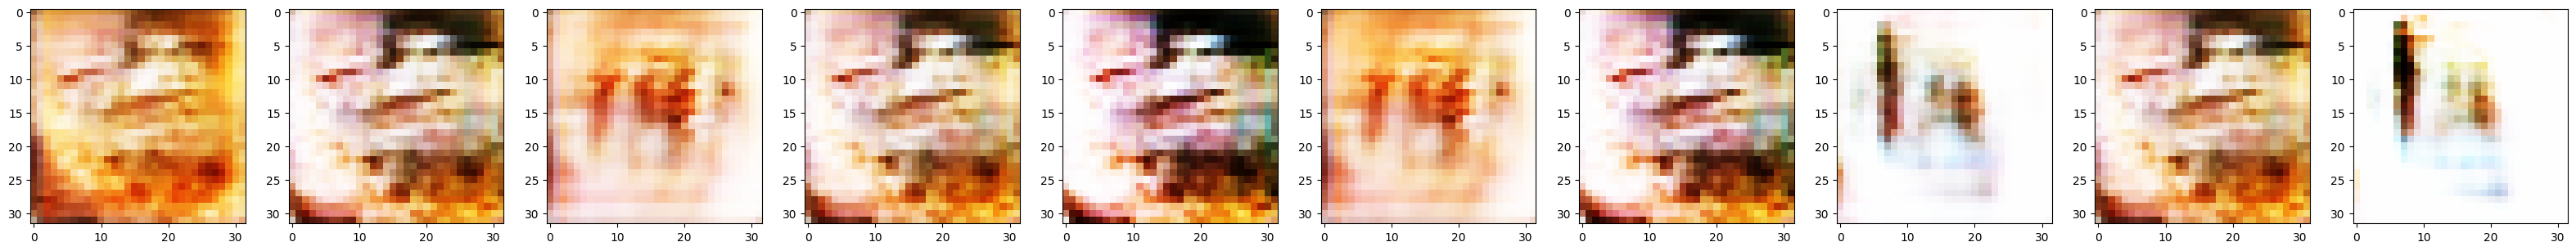

In [32]:
show_epoch(x, 2000)

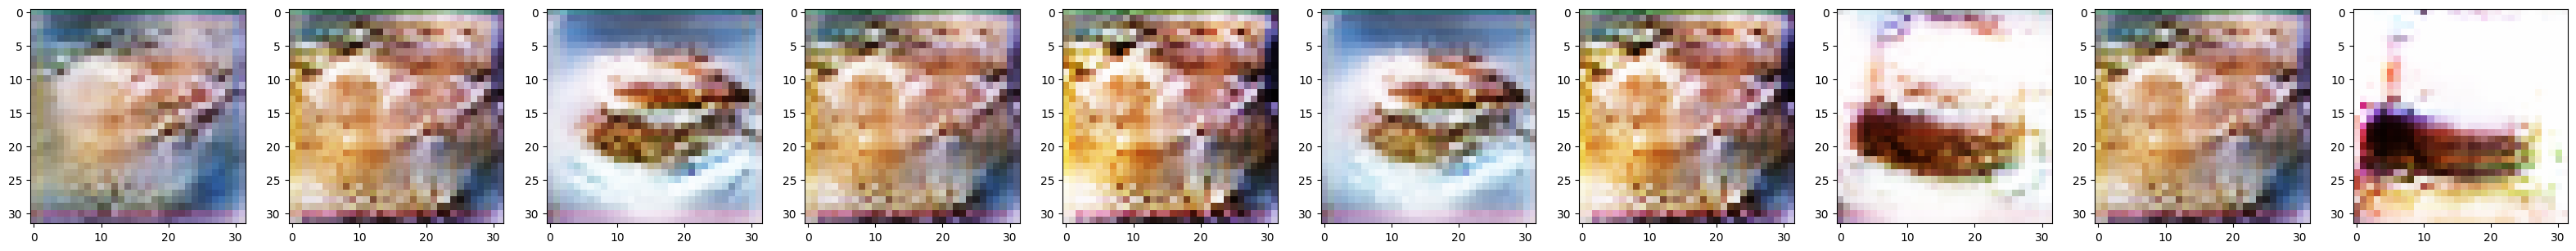

In [33]:
show_epoch(x, 2500)

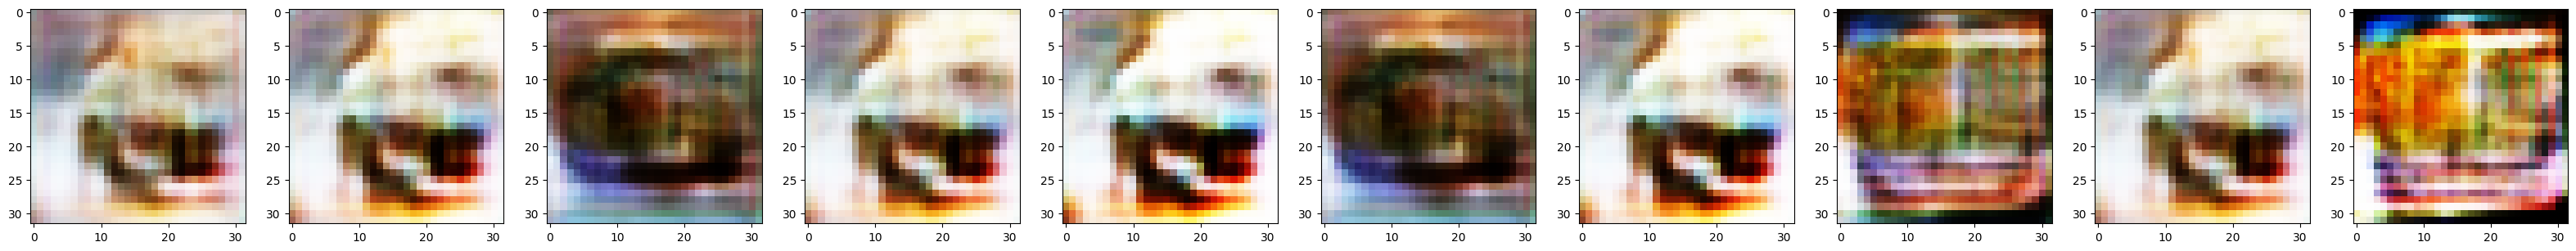

In [34]:
show_epoch(x, 3000)

Jak widać modele jak i parametry mocno oddryfowały od tych podanych w labie. Przez długi czas z domyślnymi nie mogłem uzyskać efektów inne niż różowe plamy. Z tymi modyfikacjami trening ruszył ale dalej były problemy. Na początku testowałem z ConvTransposed2d ze słabymi efektami dlatego zmieniłem na upscale + conv. 

Widać że generator wykorzystuje błędy dyskryminaora i uczy się generować tylko kilka typów obrazków. Główny podejrzany to zwiększony learning rate 